In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from scipy.signal import savgol_filter
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def pharand(u):
    # if test_a.ndim < 2:
    #     u = test_a.data[None,:].transpose() # input, time series should be the column dimension 
    # else:
    #     u = test_a.data.transpose()
    [n,m] = np.shape(u)
    n2 = np.fix(n/2)
    # if 2*n2 == n:
    #     n2 = np.int(n2)
    if 2*n2 < n:     # if odd 
        n2 = n2 + 1
    n2 = np.int(n2)
    U = np.fft.fft(u,axis=0)
    R=np.abs(U[0:n2,:])
    theta=np.random.rand(n2,m)*2*np.pi
    P=np.exp(1j*theta)
    U1top = R*P
    U2bot=np.conj(np.flipud(U1top))
    if 2*n2 == n:
        ## EVEN 
        # U1 = np.concatenate((U1top, U[n2+1,:][:,None], U2bot[1:n2,:]),axis=0) # if single column
        U1 = np.concatenate((U1top, U[n2,:][None,:], U2bot[0:n2-1,:]),axis=0)
    else:
        # ODD 
        U1 = np.concatenate((U1top, U2bot[0:n2-1,:]),axis=0)    
    U1[0,:] = U[0,:]
    u1 = np.transpose(np.real(np.fft.ifft(U1,axis=0)))
    return u1

In [3]:
# -- ECCO GRIDS -- 
# -- FOR PLOTTING -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [4]:
# -- GOM tide gauges -- 
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_2008_2017.mat')
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data['ID'][0,:]), time=(["time"], t_rec),
                            lon=(['location'], tg_data['lon'][0,:]), lat=(['location'], tg_data['lat'][0,:]),
                        ),        
                       )
tg_data_l = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_long.mat')
t_rec_l = []; 
for i in range(len(tg_data_l['t_grid'][0,:])):
    t_i_l = datetime.fromordinal(tg_data_l['t_grid'][0,i] - 366)
    t_rec_l.append(t_i_l)
data_da_l = xr.DataArray(data=tg_data_l['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data_l['ID'][0,:]), time=(["time"], t_rec_l),
                            lon=(['location'], tg_data_l['lon'][0,:]), lat=(['location'], tg_data_l['lat'][0,:]),
                        ),        
                       )
id_tags = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS', 'BAY WAVELAND' ,'SHELL BEACH', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II PIER', \
          'USCG FREEPORT', 'CORPUS CHRISTI', 'PORT ISBEL']

In [115]:
# --- tide gauge --- 
# - only over a specific decade 
# t_s = '2010-01-16'
# t_e = '2019-12-15'
t_s = '2010-05-01'
t_e = '2020-05-01'
tg_sub = data_da_l.sel(time=slice(t_s, t_e))
tg_sub_a = tg_sub - data_da_l.sel(time=slice(t_s, t_e)).mean(dim='time')
p1_test = tg_sub.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
# - total tide gauge record 
# - subset to remove mean from all years 
t_s = '1993-01-15'
t_e = '2021-06-30'
tg_sub_l = data_da_l.sel(time=slice(t_s, t_e))
tg_sub_l_a = tg_sub_l - data_da_l.sel(time=slice(t_s, t_e)).mean(dim='time')

In [116]:
for i in range(np.shape(tg_sub)[0]):
    print(np.sum(np.isnan(tg_sub[i,:].data)))

91
151
240
0
333
91
0
92
242
0
0
242
89
60
60
0
76
0
0


In [117]:
# -- Vertical Land Motion -- from multiple stations interpolated to tide gauge sites (better data)
file_int = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vlm_at_psmsl_gauges.txt")
data_int = file_int.readlines()
file_int.close()
name = []
name_row = []
for i in range(len(data_int)):
    if data_int[i][0] == '>':
        for j in range(len(data_int[i])):
            if data_int[i][j] == '\n':
                ee = j
                break
        name.append(data_int[i][9:ee])
        name_row.append(i)

In [118]:
# -- processing to get one number per tide gauge site 
id_tags = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY, ST.ANDREWS BAY, FL', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS, ALABAMA', 'BAY WAVELAND YACHT CLUB' ,'SHELL BEACH, LOUISIANA', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II, PIER 21, TX', \
          'FREEPORT', 'CORPUS CHRISTI, GULF MEXICO, TX', 'PORT ISABEL']
vlm_rate = np.nan*np.ones(len(id_tags))
vlm_un = np.nan*np.ones(len(id_tags))
for i in range(len(id_tags)):
    ii = name.index(id_tags[i])
    this_row = data_int[name_row[ii]+1].split()
    vlm_rate[i] = -1*np.float64(this_row[3])/1000  # convert from mm/yr
    vlm_un[i] = np.float64(this_row[4])/1000 # uncertainty 

In [119]:
# -- compare values 
tg_obp_trend_a = p1_test # - np.nanmean(p1_test)
print('tide gauge trend')
print(tg_obp_trend_a.data)
# print('percent of tide gauge trend from VLM')
# print(100*(rate/tg_obp_trend_a.data))
print('percent of tide gauge trend from VLM sta. interp')
print(100*(vlm_rate/tg_obp_trend_a.data))
tg_obp_trend_a = p1_test.data
tg_obp_trend_a_mvlm = p1_test.data - vlm_rate
print('VLM corrected tide gauge trend')
print(tg_obp_trend_a_mvlm)

tide gauge trend
[0.00784407 0.00986525 0.00717533 0.00745266 0.01053321 0.01025172
 0.01187458 0.01069    0.01357965 0.01447496 0.01291604 0.01159202
 0.01322059 0.01416138 0.02153392 0.02060504 0.01584774 0.01607711
 0.01482804]
percent of tide gauge trend from VLM sta. interp
[18.80401807 15.21502691 20.01300724 20.11362052 14.23118002  5.78439737
  8.96031651 16.65107204 16.51000322 14.81178556 16.11948764  8.49722229
  9.5608435  48.87941368 12.6637416  16.14653495 20.55814175 10.90370174
 11.82219598]
VLM corrected tide gauge trend
[0.00636907 0.00836425 0.00573933 0.00595366 0.00903421 0.00965872
 0.01081058 0.00891    0.01133765 0.01233096 0.01083404 0.01060702
 0.01195659 0.00723938 0.01880692 0.01727804 0.01258974 0.01432411
 0.01307504]


In [120]:
# PHASE SCRAMBLING
# test = tg_sub[0:2].interpolate_na(dim='time',method='linear') # time series 
# test_a = test - test.mean(dim='time')
test_a = tg_sub_a.interpolate_na(dim='time',method='linear')
# -- consider input dimension, want [time, station]
# - if more than 1d
data_in = test_a.data.transpose()
# if a single column
# data_in = test_a.data[:,None]
n_s = 1000
scram_trend = np.nan*np.ones((n_s,np.shape(data_in)[1]))
for i in range(0,n_s):
    scram = pharand(data_in)
    u1_da = xr.DataArray(data=scram, dims=["location","time"],
                        coords=dict(
                            location=(["location"], np.arange(0,np.shape(scram)[0])), time=(["time"], test_a.time.data)))
    slope = u1_da.polyfit(dim='time', deg=1)
    scram_trend[i,:] = (slope.isel(degree=0).polyfit_coefficients.data)*1e9*60*60*24*365 - vlm_rate

(0.0, 100.0)

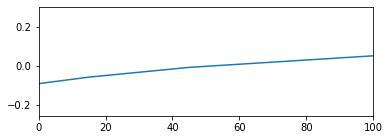

In [121]:
f, ax = plt.subplots(1,1,figsize=(6,2))
ax.plot(np.arange(0,len(data_in[:,4])),data_in[:,4])
# ax.plot(np.arange(0,len(data_in[:,2])),tg_sub_a[2,:])
ax.set_xlim([0,100])

In [122]:
np.nanstd(scram_trend,axis=0)

array([0.00406796, 0.00421497, 0.0049884 , 0.00365757, 0.00456873,
       0.005738  , 0.00593679, 0.00518954, 0.00711393, 0.00720868,
       0.0057611 , 0.00642111, 0.00640963, 0.00720714, 0.01154201,
       0.01169249,        nan, 0.00870188, 0.00827805])

In [123]:
p1_test.data - vlm_rate

array([0.00636907, 0.00836425, 0.00573933, 0.00595366, 0.00903421,
       0.00965872, 0.01081058, 0.00891   , 0.01133765, 0.01233096,
       0.01083404, 0.01060702, 0.01195659, 0.00723938, 0.01880692,
       0.01727804, 0.01258974, 0.01432411, 0.01307504])

In [129]:
for ii in range(np.shape(scram_trend)[1]):
    print(id_tags[ii] + ' tg:' + str(np.round(1000*p1_test[ii].data,4)) + ', std:' + str(np.round(np.nanstd(1000*scram_trend[:,ii]),4)))

KEY WEST tg:7.8441, std:4.068
NAPLES tg:9.8652, std:4.215
FORT MYERS tg:7.1753, std:4.9884
ST. PETERSBURG tg:7.4527, std:3.6576
CLEARWATER BEACH tg:10.5332, std:4.5687
CEDAR KEY II tg:10.2517, std:5.738
APALACHICOLA tg:11.8746, std:5.9368
PANAMA CITY, ST.ANDREWS BAY, FL tg:10.69, std:5.1895
PENSACOLA tg:13.5796, std:7.1139
DAUPHIN ISLAND tg:14.475, std:7.2087
MOBILE STATE DOCKS, ALABAMA tg:12.916, std:5.7611
BAY WAVELAND YACHT CLUB tg:11.592, std:6.4211
SHELL BEACH, LOUISIANA tg:13.2206, std:6.4096
GRAND ISLE tg:14.1614, std:7.2071
SABINE PASS tg:21.5339, std:11.542
GALVESTON II, PIER 21, TX tg:20.605, std:11.6925
FREEPORT tg:15.8477, std:nan
CORPUS CHRISTI, GULF MEXICO, TX tg:16.0771, std:8.7019
PORT ISABEL tg:14.828, std:8.278


tg:0.0078, std:0.0041
tg:0.0099, std:0.0042
tg:0.0072, std:0.005
tg:0.0075, std:0.0037
tg:0.0105, std:0.0046
tg:0.0103, std:0.0057
tg:0.0119, std:0.0059
tg:0.0107, std:0.0052
tg:0.0136, std:0.0071
tg:0.0145, std:0.0072
tg:0.0129, std:0.0058
tg:0.0116, std:0.0064
tg:0.0132, std:0.0064
tg:0.0142, std:0.0072
tg:0.0215, std:0.0115
tg:0.0206, std:0.0117


ValueError: autodetected range of [nan, nan] is not finite

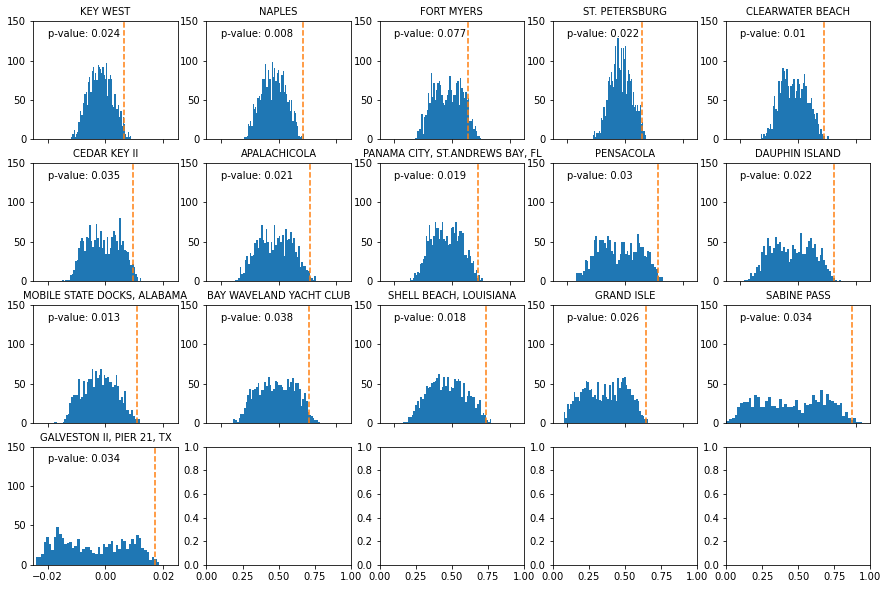

In [124]:
combo_dist = np.concatenate((scram_trend,(p1_test.data - vlm_rate)[None,:]),axis=0)
zscores = stats.zscore(combo_dist,axis=0)
p_value = stats.norm.sf(abs(zscores[-1,:]))

f, ax = plt.subplots(4,5,figsize=(15,10))
gax = ax.flatten()
for ii in range(np.shape(scram_trend)[1]):
    ah = gax[ii].hist(scram_trend[:,ii],50,density=True)
    gax[ii].plot([p1_test[ii],p1_test[ii]] - vlm_rate[ii],[0,150],linestyle='--')
    gax[ii].set_ylim([0,150])
    gax[ii].set_xlim([-0.025,0.025])
    gax[ii].text(-0.02,130,'p-value: ' + str(np.round(p_value[ii],3)))
    gax[ii].set_title(id_tags[ii],fontsize=10)
    if ii < 15:
        gax[ii].set_xticklabels('')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_08_18/tg_2010_2019_trend_dist.jpg', dpi=250)

In [37]:
p_value

array([0.03014415, 0.01242292,        nan, 0.02691711,        nan,
       0.03711275, 0.02133846, 0.01613784, 0.02087284, 0.01887848,
       0.00865009, 0.02450254, 0.01595549, 0.02332227, 0.03049435,
       0.03471052,        nan, 0.02895452, 0.03049862])

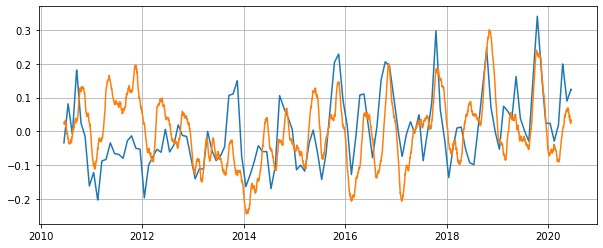

In [44]:
f, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(tg_sub.time,test_a[-1,:])
ax.plot(tg_sub.time,scram[-1,:])
ax.grid()

169.32778333535643
222.37152708581237
152.5856811268344
158.28379119478961
240.1831186669162
256.78622786030553
287.4096465434681
236.88095491164185
301.42218850975723
327.8303857652736
288.0334262049654
281.997886095488
317.8774291429524
192.46588353093642
500.0
459.3532586534577
334.7101961498388
380.8201656000792
347.6124837325958


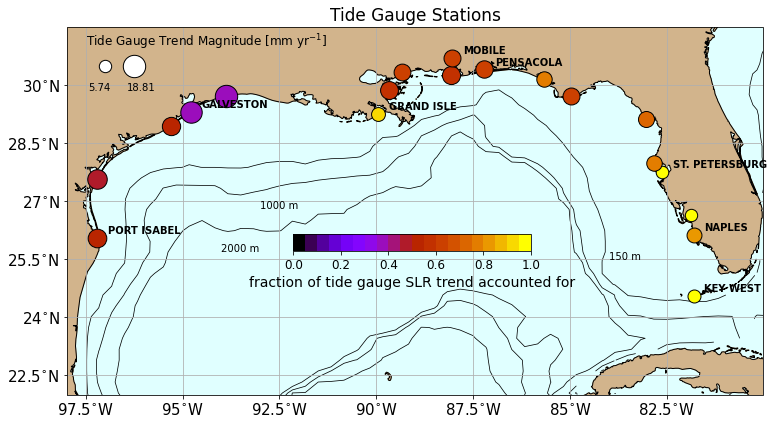

In [126]:
# Locations 
# TAKE FROM SEPARATE ESTIMATES 
argo = 0.00472 # OLD = 0.00742
argo_grace = argo + 0.0021 # 2022-01-01 -- 2022-12-31 = 0.0032 # old grace = 0.00355 
cmap = mpl.cm.get_cmap('gnuplot',20)
clow = 0; chigh = 1; norm = mpl.colors.Normalize(vmin=clow, vmax=chigh)

id_tags_short = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY, ST.ANDREWS BAY, FL', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE', 'BAY WAVELAND YACHT CLUB' ,'SHELL BEACH, LOUISIANA', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON', \
          'FREEPORT', 'CORPUS CHRISTI, GULF MEXICO, TX', 'PORT ISABEL']

sf = 500
f, ax = plt.subplots(1,1,figsize=(11,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for i in range(len(tg_data['lat'][0,:])):
    # s_i = 1*(tg_obp_trend_a[i] - vlm_rate[i])/(np.nanmax(tg_obp_trend_a - vlm_rate) - np.nanmin(tg_obp_trend_a - vlm_rate))
    s_i = sf*(tg_obp_trend_a[i] - vlm_rate[i])/(np.nanmax(tg_obp_trend_a - vlm_rate))
    print(s_i)
    ax.scatter(tg_data['lon'][0,i],tg_data['lat'][0,i], \
               color=cmap(argo_grace/(tg_obp_trend_a[i] - vlm_rate[i])),\
               s=s_i,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')

ax.scatter(-97,30.5,sf*np.nanmin(tg_obp_trend_a - vlm_rate)/(np.nanmax(tg_obp_trend_a - vlm_rate)),\
           color='w',transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
ax.text(-97.45,29.85,str(np.round(1000*np.nanmin(tg_obp_trend_a - vlm_rate),2)))
ax.scatter(-96.25,30.5,sf*np.nanmax(tg_obp_trend_a - vlm_rate)/(np.nanmax(tg_obp_trend_a - vlm_rate)),\
           color='w',transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
ax.text(-96.45,29.85,str(np.round(1000*np.nanmax(tg_obp_trend_a - vlm_rate),2)))
ax.text(-97.5,31,'Tide Gauge Trend Magnitude [mm yr$^{-1}$]',fontsize=12)
    
i0 = 1
i1 = 3
i2 = 10
i3 = 13
i4 = 18
ii = [0,1,3,8,10,13,15,18]
for i in ii:
    ax.text(tg_data['lon'][0,i]+0.28,tg_data['lat'][0,i]+0.1,id_tags_short[i],fontsize=10,fontweight='bold')

ax.contour(lons,lats,dep,levels=[150],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-84,25.5,'150 m', color='k')
ax.contour(lons,lats,dep,levels=[1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-93,26.8,'1000 m', color='k')
ax.contour(lons,lats,dep,levels=[2000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-94,25.7,'2000 m', color='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
gl.xlabels_bottom = False; gl.ylabels_left = False;
ax.set_xlim([-98,-80]); ax.set_ylim([22,31.5]);
ax.set_title('Tide Gauge Stations',fontsize=17) 
ax.set_xticks(np.arange(-97.5,-80,2.5))
ax.set_xticklabels(['97.5$^{\circ}$W','95$^{\circ}$W','92.5$^{\circ}$W','90$^{\circ}$W',\
                    '87.5$^{\circ}$W','85$^{\circ}$W','82.5$^{\circ}$W'],fontsize=15)
ax.set_yticks(np.arange(22.5,31.5,1.5))
ax.set_yticklabels(['22.5$^{\circ}$N','24$^{\circ}$N','25.5$^{\circ}$N','27$^{\circ}$N',\
                    '28.5$^{\circ}$N','30$^{\circ}$N'],fontsize=15)

ax.set_facecolor('#E0FFFF');
cbpos = [0.375, 0.41, 0.3, 0.04]; cax = f.add_axes(cbpos); 
cb = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label='fraction of tide gauge trend accounted for')
cb.set_label('fraction of tide gauge SLR trend accounted for', fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures_v1/f13_tide_gauge_stations.jpg', dpi=300)

In [31]:
# -- LOAD LOTS OF AVISO for comp at tide gauges (MERGE larger datasets for a zoomed out view) 
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1993_1998.nc'
av1 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1999_2004.nc'
av2 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2005_2010.nc'
av3 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2011_2016.nc'
av4 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2017_2021.nc'
av5 = xr.open_dataset(av_path)
av_tot = xr.concat([av1,av2,av3,av4,av5], dim='time')

In [32]:
# AVISO temporal anomaly 
avsla_raw = av_tot.sla
avsla_raw_tot = avsla_raw.sel(time=slice("1993-01-01", "2021-08-02"))
avsla_raw_tot_mean = avsla_raw_tot.mean(dim='time')
avsla_raw_tot_a = avsla_raw_tot - avsla_raw_tot_mean

In [46]:
# interpolate to tide gauge locations 
avsla_raw_tot_a_sub_ar = avsla_raw_tot_a.sel(time=slice("2010-01-01", "2019-12-31"))
pavsla_star_ar = avsla_raw_tot_a_sub_ar.polyfit(dim='time', deg=1)  
# find AVISO nearest to tide gauge
nb_trend = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    avlonii = np.where((av_tot.longitude > sta_lon-.25) & (av_tot.longitude < sta_lon+.25))[0]
    avlatii = np.where((av_tot.latitude > sta_lat-.25) & (av_tot.latitude < sta_lat+.25))[0]
    coef = np.nanmean(pavsla_star_ar.polyfit_coefficients.data[0, avlatii][:,avlonii])
    nb_trend[i] = np.round(coef*1e9*60*60*24*365,5)

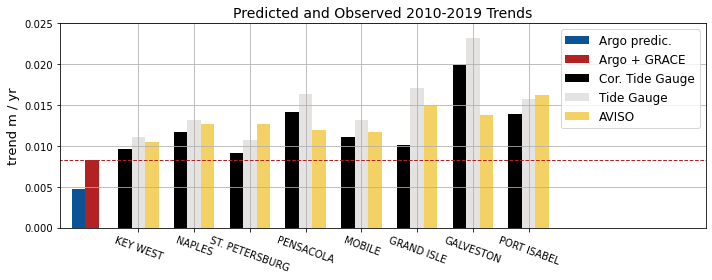

In [52]:
f, ax = plt.subplots(1,1,figsize=(10,4),tight_layout=True); ax.grid()
wid = 0.145

ax.bar(0.5, argo, width=wid,label='Argo predic.',color='#0b5394')
ax.bar(0.5+wid, argo_grace, width=wid,label='Argo + GRACE',color='#B22222')

wid = 0.145
ii = [0,1,3,8,10,13,15,18]
ipos = np.array([1,1.6,2.2,2.8,3.4,4,4.6,5.2])
for i in range(len(ii)):
    if i < 1:
        ax.bar(i+1,tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],width=wid,label='Cor. Tide Gauge',color='k') # #4a4a4a')
        # ax.errorbar(i+1,tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],yerr=vlm_un[ii[i]],capsize=3, color='r')
        ax.bar(i+1+wid,tg_obp_trend_a[ii[i]],width=wid,label='Tide Gauge', color='#e5e2e2')
        ax.bar(i+1+2*wid,nb_trend[ii[i]],width=wid, label='AVISO', color='#f1c232',alpha=0.75)
    else:
        ax.bar((ipos[i]),tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],width=wid,color='k') # '#4a4a4a')
        # ax.errorbar((ipos[i]),tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],yerr=vlm_un[ii[i]],capsize=3,color='r')
        ax.bar((ipos[i]) + wid,tg_obp_trend_a[ii[i]],width=wid,color='#e5e2e2')
        ax.bar((ipos[i]) + 2*wid,nb_trend[ii[i]],width=wid,color='#f1c232',alpha=0.75)

ax.plot([0,8],[argo_grace,argo_grace],color='#B22222',linestyle='--',linewidth=1)
ax.set_xlim([.3,7.25]); ax.set_xticks(ipos+wid); 
ax.set_xticklabels([id_tags_short[ii[0]],id_tags_short[ii[1]],id_tags_short[ii[2]][0:18],\
                    id_tags_short[ii[3]],id_tags_short[ii[4]],id_tags_short[ii[5]],\
                    id_tags_short[ii[6]],id_tags_short[ii[7]]], rotation=-20)
ax.set_ylim([0,0.025])
ax.set_title('Predicted and Observed 2010-2019 Trends', fontsize=14); ax.set_ylabel('trend m / yr',fontsize=13); ax.legend(loc=0,fontsize=12); 
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/tide_gauge_bar_comp.jpg', dpi=250)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_07/synthesis_5stations.jpg', dpi=250)